# Import

In [66]:
import os
import random
import shutil
import numpy as np
from collections import defaultdict
from PIL import Image, ImageEnhance, ImageOps, ImageFilter, ImageOps
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


# ------------------- Torch --------------------------------#
import torch
from torchvision.transforms.functional import to_pil_image
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [67]:
# if GPU is available , use it while training 
device = "cuda" if torch.cuda.is_available() else "cpu" 
device

'cpu'

# Load models

In [68]:
# Load pre-trained ResNet50 model
resnet = models.resnet50(pretrained=True)

# Modify the last fully connected layer to match the number of classes in your dataset
num_classes = 8  # Change this according to your dataset
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

# Optionally, if you want to freeze the weights of the pre-trained layers
for param in resnet.parameters():
    param.requires_grad = False

class SimpleCNN(nn.Module):
    def __init__(self, backbone, num_classes):
        super(SimpleCNN, self).__init__()
        self.backbone = backbone

        # Add additional layers if needed
        self.fc = nn.Linear(2048, num_classes)  # Input size is fixed for ResNet50

    def forward(self, x):
        features = self.backbone(x)
        out = self.fc(features)
        return out

resnet.fc = nn.Identity()  # Remove the final fully connected layer of ResNet50

# Instantiate your SimpleCNN model with ResNet50 backbone
base_model = SimpleCNN(resnet, num_classes)

c:\Users\asche\anaconda3\envs\ailab\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\asche\anaconda3\envs\ailab\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [69]:
# Load the saved state dictionary
model_a = torch.load('./models/trained_model1b.pth') # model_a = torch.load('./models/trained_model1.pth')
# model_b = torch.load('./models/trained_model3.pth')
# model_c = torch.load('./models/trained_model5.pth') # done

In [70]:
# 8 output units
num_features_a = model_a.fc.in_features
# num_features_b = model_b.fc.in_features
# num_features_c = model_c.fc.in_features

# Adjust the number of output units 
model_a.fc = torch.nn.Linear(num_features_a, 8)  
# model_b.fc = torch.nn.Linear(num_features_b, 8)  
# model_c.fc = torch.nn.Linear(num_features_c, 8)  

In [71]:
# Load state dictionary into model
# Set strict to False to ignore missing keys
# model_a.load_state_dict(model_a, strict=False)  
# model_b.load_state_dict(model_b, strict=False) 
# model_c.load_state_dict(model_c, strict=False)  

In [72]:
# Ensure the model is in evaluation mode
model_a.eval()
# model_b.eval()
# model_c.eval()

SimpleCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [73]:
root_dir = '../Downloading_images/data/'

In [74]:
# Define the path to the models folder
models_folder = './models/'

In [75]:
# path to train and validation sets
train_dir= "../Downloading_images/data/train/" # path to the train folder
validation_dir= "../Downloading_images/data/val" # path to the validation folder
test_dir= "../Downloading_images/data/test" # path to the test folder

# variables for the paths.
train_dir = train_dir
validation_dir = validation_dir
test_dir = test_dir

# Transform

In [76]:
width = 224
height = 224


test_transform  = transforms.Compose([
transforms.Resize(size=(width, height)),
transforms.ToTensor()  
])

test_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)

In [77]:
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

print(f"Test data:\n{test_data}")

Test data:
Dataset ImageFolder
    Number of datapoints: 8400
    Root location: ../Downloading_images/data/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [78]:
# create with datasets.ImageFolder
test_set = DataLoader(dataset=test_data,
                            batch_size=32,
                            num_workers=1,
                            shuffle=False) # dont usually need to shuffle testing data

test_set

In [79]:
# I create train_data above , and I will use it here
label_dict = {y: x for x, y in test_data.class_to_idx.items()}

In [80]:
# Convert keys in label_dict to integers
label_dict_int = {int(key): value for key, value in label_dict.items()}
print(label_dict_int)

{0: '130228', 1: '47892', 2: '48537', 3: '48681', 4: '593040', 5: '59549', 6: '83653', 7: '914922'}


In [84]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Initialize variables to store evaluation metrics
accuracy = 0
precision = 0
recall = 0
f1 = 0
auc = 0

# Evaluate the model
with torch.no_grad():
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    for images, labels in test_set:
        # Preprocess the test data (if needed)
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_a(images)
        _, predicted = torch.max(outputs, 1)
        
        # Store predictions and true labels for later calculation
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        # Compute accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')
    # auc = roc_auc_score(true_labels, predictions, multi_class='ovo')


# Print evaluation metrics
print('Test Accuracy: {:.2f}%'.format(100 * accuracy))
print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1-score: {:.2f}'.format(f1))
# print('AUC: {:.2f}'.format(auc))


Test Accuracy: 14.54%
Precision: 0.09
Recall: 0.15
F1-score: 0.11


In [85]:
predictions_name = 'predictions_model_a.npy'

In [86]:
# Check if the file exists
if os.path.exists(predictions_name):
    # Load predictions from the file
    all_predictions = np.load(predictions_name, allow_pickle=True)
    print("Predictions loaded from file.")
else:
    # Run the prediction process
    # Define data transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Perform prediction sampling and aggregate predictions
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_set:
            images = images.to(device)
            predictions = []
            for _ in range(10):  # usually 10-100
                outputs = model_a(images)
                probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
                predictions.append(probabilities)
            all_predictions.append(np.mean(predictions, axis=0))


Predictions loaded from file.


In [87]:
# Save predictions to a file
np.save(predictions_name, all_predictions)
print("Predictions saved to file.")

Predictions saved to file.


In [88]:
num_classes = len(label_dict)
print(num_classes)

# Map class indices to labels
class_labels = [label_dict[i] for i in range(num_classes)]
print(class_labels)

8
['130228', '47892', '48537', '48681', '593040', '59549', '83653', '914922']


In [89]:
# Visualize posterior probabilities for the first image
posterior_probabilities = all_predictions[0] 

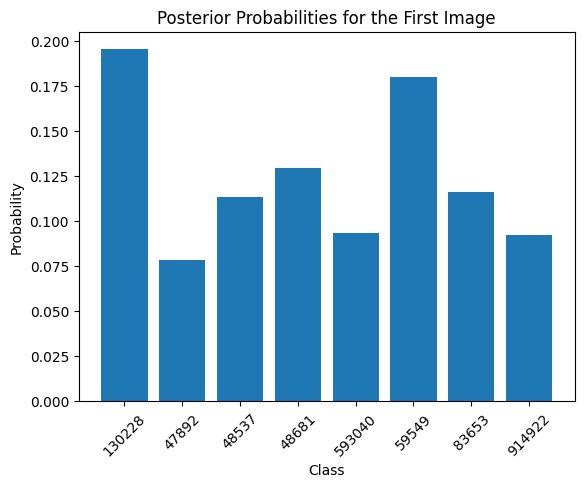

In [90]:
# Convert posterior probabilities to a numpy array
posterior_probabilities = np.array(posterior_probabilities[0])

# Create a bar plot
plt.figure()
plt.bar(np.arange(len(class_labels)), posterior_probabilities)
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Posterior Probabilities for the First Image')
plt.xticks(np.arange(len(class_labels)), class_labels, rotation=45)
plt.show()

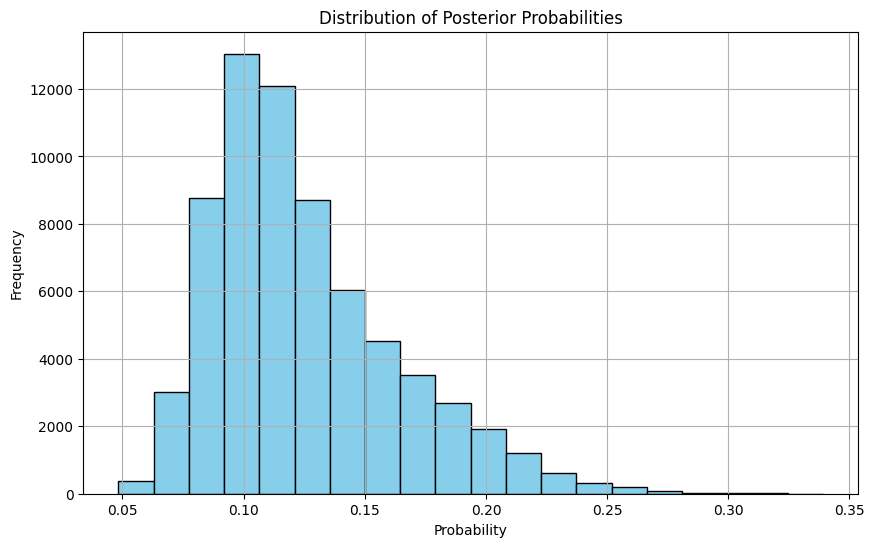

In [91]:
# Concatenate all posterior probabilities from all images
all_posterior_probabilities = np.concatenate(all_predictions, axis=0)

# Flatten the array to get a 1D array of probabilities
flat_posterior_probabilities = all_posterior_probabilities.flatten()

# Plot the histogram of posterior probabilities
plt.figure(figsize=(10, 6))
plt.hist(flat_posterior_probabilities, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Posterior Probabilities')
plt.grid(True)
plt.show()

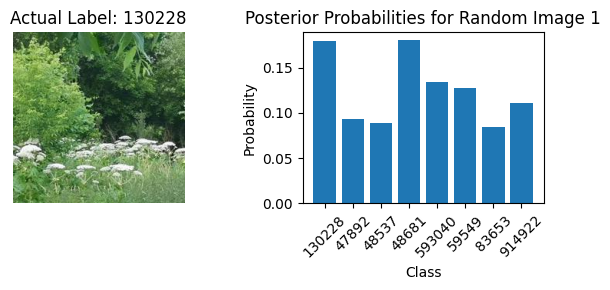

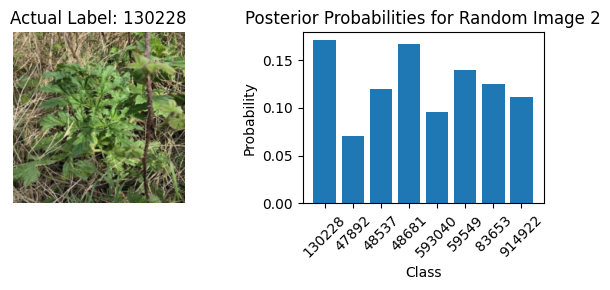

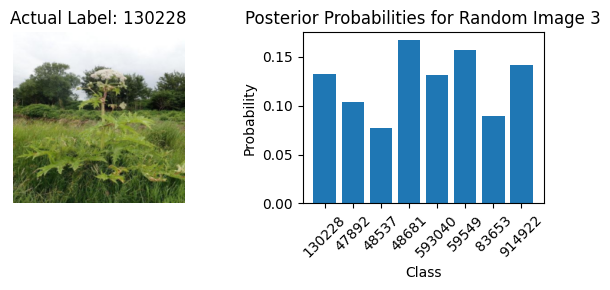

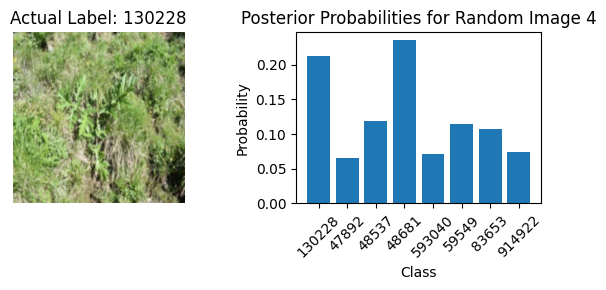

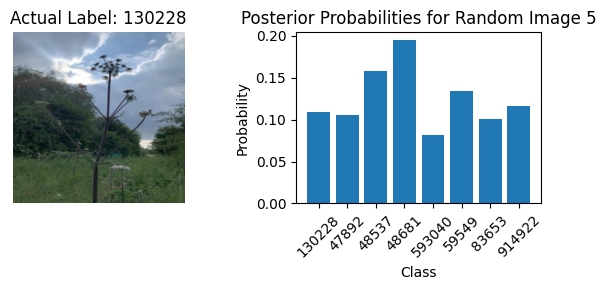

In [92]:
def visualize_random_images(all_predictions, label_dict, dataset, num_images=5):
    # Get the total number of images in the dataset
    total_images = len(dataset)

    # Generate random indices to select random images
    random_indices = random.sample(range(total_images), num_images)
    random_indices = [index % len(all_predictions) for index in random_indices]

    # Iterate over the randomly selected images
    for i, index in enumerate(random_indices):
        # Extract posterior probabilities for the current image
        posterior_probabilities = all_predictions[index]

        # Extracting class labels from the label dictionary
        class_labels = list(label_dict.values())

        # Convert posterior probabilities to a numpy array
        posterior_probabilities = np.array(posterior_probabilities[0])

        # Retrieve the actual image and its label from the dataset
        image, label_index = dataset[index]
        actual_label = label_dict[label_index]

        # Plot the image
        plt.figure(figsize=(6, 3))
        plt.subplot(1, 2, 1)
        plt.imshow(image.permute(1, 2, 0))  # Assuming image is a PyTorch tensor
        plt.axis('off')
        plt.title(f'Actual Label: {actual_label}')

        # Create a bar plot for posterior probabilities
        plt.subplot(1, 2, 2)
        plt.bar(np.arange(len(class_labels)), posterior_probabilities)
        plt.xlabel('Class')
        plt.ylabel('Probability')
        plt.title(f'Posterior Probabilities for Random Image {i+1}')
        plt.xticks(np.arange(len(class_labels)), class_labels, rotation=45)
        plt.tight_layout()
        plt.show()

# Example usage: visualize posterior probabilities for 5 random images
visualize_random_images(all_predictions, label_dict, test_data, num_images=5)

In [93]:
prediction_probabilities = all_predictions  

# Extract true labels from your test dataset
true_labels = np.array([label for _, label in test_data])

In [94]:
prediction_probabilities = np.vstack(prediction_probabilities)

In [95]:
# Calculate prediction errors (cross-entropy loss)
# Use true labels to index prediction probabilities
prediction_errors = -np.log(prediction_probabilities[np.arange(len(true_labels)), true_labels])

In [96]:
# Calculate uncertainty measures (e.g., entropy)
entropy = -np.sum(prediction_probabilities * np.log(prediction_probabilities), axis=1)

# Calculate correlation between uncertainty and prediction errors
correlation = np.corrcoef(entropy, prediction_errors)[0, 1]

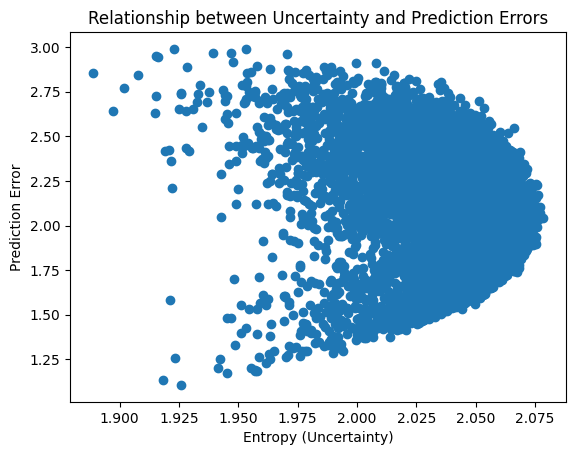

Correlation between uncertainty and prediction errors: -0.16297765435247769


In [97]:
# Visualize the relationship
plt.scatter(entropy, prediction_errors)
plt.xlabel('Entropy (Uncertainty)')
plt.ylabel('Prediction Error')
plt.title('Relationship between Uncertainty and Prediction Errors')
plt.show()

print("Correlation between uncertainty and prediction errors:", correlation)

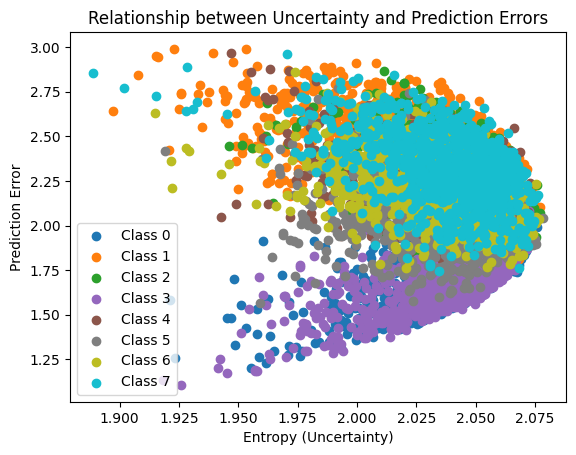

Correlation between uncertainty and prediction errors: -0.16297765435247769


In [ ]:
# Get unique class labels
unique_labels = np.unique(true_labels)

# Create a colormap with a unique color for each class
num_classes = len(unique_labels)
colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

# Plot each class separately with a unique color
for label, color in zip(unique_labels, colors):
    indices = np.where(true_labels == label)
    plt.scatter(entropy[indices], prediction_errors[indices], label=f'Class {label}', color=color)

plt.xlabel('Entropy (Uncertainty)')
plt.ylabel('Prediction Error')
plt.title('Relationship between Uncertainty and Prediction Errors')
plt.legend()
plt.show()

print("Correlation between uncertainty and prediction errors:", correlation)

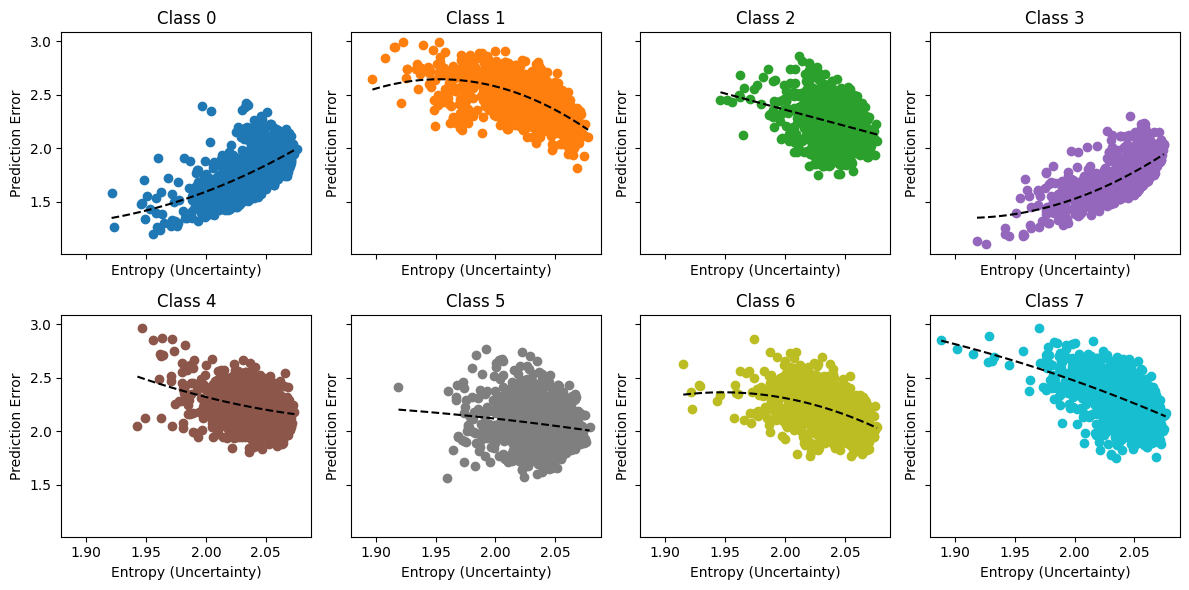

In [ ]:
# Create subplots
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)

# Plot each class separately with a unique color
for i, (label, color) in enumerate(zip(unique_labels, colors)):
    row = i // 4
    col = i % 4
    indices = np.where(true_labels == label)
    axes[row, col].scatter(entropy[indices], prediction_errors[indices], label=f'Class {label}', color=color)
    axes[row, col].set_title(f'Class {label}')
    axes[row, col].set_xlabel('Entropy (Uncertainty)')
    axes[row, col].set_ylabel('Prediction Error')
    
    # Fit polynomial regression
    degree = 2
    poly_features = np.column_stack([entropy[indices], entropy[indices]**2])  # Create polynomial features
    lr = LinearRegression()
    lr.fit(poly_features, prediction_errors[indices])
    line_x = np.linspace(np.min(entropy[indices]), np.max(entropy[indices]), 100)
    line_y = lr.predict(np.column_stack([line_x, line_x**2]))  # Predict using polynomial features
    
    # Plot polynomial regression line
    axes[row, col].plot(line_x, line_y, color='black', linestyle='--')

# Adjust layout
plt.tight_layout()
plt.show()